<h2>Importando bibliotecas necessarias

In [51]:
import requests
import pandas as pd
from datetime import datetime
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt

<h2>Obtendo Dados via SQL da base da Aneel e utilizando as colunas necessarias

In [52]:
# URL base da API para consultas SQL
url = "https://dadosabertos.aneel.gov.br/api/3/action/datastore_search_sql"

# Consulta SQL
query = """
    SELECT "SigAgente", "DatInicioVigencia", "DatFimVigencia", "DscSubGrupo", "DscModalidadeTarifaria", "VlrTUSD", "VlrTE", "DscUnidadeTerciaria", "NomPostoTarifario", "DscDetalhe"
    FROM "fcf2906c-7c32-4b9b-a637-054e7a5234f4"
    WHERE "DatInicioVigencia" >= '2020-01-01'
    AND (("DscSubGrupo" = 'B3' AND ("DscModalidadeTarifaria" = 'Branca' OR "DscModalidadeTarifaria" = 'Convencional'))
    OR (("DscSubGrupo" = 'A4' OR "DscSubGrupo" = 'A2')
    AND ("DscModalidadeTarifaria" = 'Azul' OR "DscModalidadeTarifaria" = 'Verde')))
    AND ("DscBaseTarifaria" = 'Tarifa de Aplicação')
"""

# Monta a URL com a query
params = {"sql": query}

print("Fazendo a requisição dos dados...")
# Fazendo a requisição
response = requests.get(url, params=params)

# Verifica se a requisição foi bem-sucedida
data = response.json()  # Converte a resposta JSON em um dicionário Python
records = data.get("result", {}).get("records", [])  # Obtém os registros da resposta

print("Criando DataFrame...")
# Cria um DataFrame a partir dos dados
df = pd.DataFrame(records)
df.head(5)

Fazendo a requisição dos dados...
Criando DataFrame...


,SigAgente,DatInicioVigencia,DatFimVigencia,DscSubGrupo,DscModalidadeTarifaria,VlrTUSD,VlrTE,DscUnidadeTerciaria,NomPostoTarifario,DscDetalhe
0,EMT,2020-07-01,2021-04-07,A2,Azul,"18,57",",00",kW,Ponta,APE
1,EMR,2020-06-22,2020-06-30,A2,Azul,"22,44",",00",kW,Ponta,APE
2,EMS,2020-07-01,2021-04-07,A4,Azul,"60,61",",00",kW,Ponta,APE
3,EMT,2020-04-08,2020-06-30,A4,Azul,"44,65",",00",kW,Ponta,APE
4,CERCI,2020-04-29,2020-06-30,A4,Azul,"28,68",",00",MWh,Ponta,APE


Analise dos dados

In [53]:
df.info() #todos os dados vieram como objetos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14602 entries, 0 to 14601
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   SigAgente               14602 non-null  object
 1   DatInicioVigencia       14602 non-null  object
 2   DatFimVigencia          14602 non-null  object
 3   DscSubGrupo             14602 non-null  object
 4   DscModalidadeTarifaria  14602 non-null  object
 5   VlrTUSD                 14602 non-null  object
 6   VlrTE                   14602 non-null  object
 7   DscUnidadeTerciaria     14602 non-null  object
 8   NomPostoTarifario       14602 non-null  object
 9   DscDetalhe              14602 non-null  object
dtypes: object(10)
memory usage: 1.1+ MB


Converter colunas necessarias

In [54]:
# Limpeza e conversão segura para float
df["VlrTUSD"] = pd.to_numeric(df["VlrTUSD"].astype(str).str.replace(",", "."), errors='coerce')
df["VlrTE"] = pd.to_numeric(df["VlrTE"].astype(str).str.replace(",", "."), errors='coerce')

#Converter as colunas de datas que vieram em formato Object 
df["DatFimVigencia"] = pd.to_datetime(df["DatFimVigencia"], errors="coerce")
df["DatInicioVigencia"] = pd.to_datetime(df["DatInicioVigencia"], errors="coerce")

#Verificar as colunas se estao corretas agora
df.info()
df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14602 entries, 0 to 14601
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   SigAgente               14602 non-null  object        
 1   DatInicioVigencia       14602 non-null  datetime64[ns]
 2   DatFimVigencia          14602 non-null  datetime64[ns]
 3   DscSubGrupo             14602 non-null  object        
 4   DscModalidadeTarifaria  14602 non-null  object        
 5   VlrTUSD                 14602 non-null  float64       
 6   VlrTE                   14602 non-null  float64       
 7   DscUnidadeTerciaria     14602 non-null  object        
 8   NomPostoTarifario       14602 non-null  object        
 9   DscDetalhe              14602 non-null  object        
dtypes: datetime64[ns](2), float64(2), object(6)
memory usage: 1.1+ MB


,SigAgente,DatInicioVigencia,DatFimVigencia,DscSubGrupo,DscModalidadeTarifaria,VlrTUSD,VlrTE,DscUnidadeTerciaria,NomPostoTarifario,DscDetalhe
0,EMT,2020-07-01,2021-04-07,A2,Azul,18.57,0.0,kW,Ponta,APE
1,EMR,2020-06-22,2020-06-30,A2,Azul,22.44,0.0,kW,Ponta,APE
2,EMS,2020-07-01,2021-04-07,A4,Azul,60.61,0.0,kW,Ponta,APE


Fazer os calculos necessarios

In [55]:
#Calculo da coluna da Tarifa 
df["Tarifa Vigente"] = df["VlrTUSD"] + df["VlrTE"]
#Calulo da Tarifa considerando Pis Cofins e ICMS teorico de 0.95
df["TarifaPisCofinsICMS"] = (df["VlrTUSD"] + df["VlrTE"]) / 0.95

#Verificar se a tarifa aida continua Vigente
#Utilizando a Data de hoje para comparar com a data de fim de vigencia
data_atual = datetime.today()

df["Alerta"] = df["DatFimVigencia"].apply(lambda x: "Não Vigente" if x < data_atual else "Vigente")

tarifas_vencidas = df[df["Alerta"] == "Não Vigente"]

if not tarifas_vencidas.empty:
    print("ALERTA: Existem tarifas Não Vigentes!")

df.head(5)


ALERTA: Existem tarifas Não Vigentes!


,SigAgente,DatInicioVigencia,DatFimVigencia,DscSubGrupo,DscModalidadeTarifaria,VlrTUSD,VlrTE,DscUnidadeTerciaria,NomPostoTarifario,DscDetalhe,Tarifa Vigente,TarifaPisCofinsICMS,Alerta
0,EMT,2020-07-01,2021-04-07,A2,Azul,18.57,0.0,kW,Ponta,APE,18.57,19.547368,Não Vigente
1,EMR,2020-06-22,2020-06-30,A2,Azul,22.44,0.0,kW,Ponta,APE,22.44,23.621053,Não Vigente
2,EMS,2020-07-01,2021-04-07,A4,Azul,60.61,0.0,kW,Ponta,APE,60.61,63.800000,Não Vigente
3,EMT,2020-04-08,2020-06-30,A4,Azul,44.65,0.0,kW,Ponta,APE,44.65,47.000000,Não Vigente
4,CERCI,2020-04-29,2020-06-30,A4,Azul,28.68,0.0,MWh,Ponta,APE,28.68,30.189474,Não Vigente


Correlação

In [56]:
# Seleciona colunas relevantes desconsiderando o nome da concessionaria
df_corr = df[["DscSubGrupo", "DscModalidadeTarifaria", "NomPostoTarifario", "Tarifa Vigente"]].copy()
# Selecionando as colunas categóricas
cat_cols = ["DscSubGrupo", "DscModalidadeTarifaria", "NomPostoTarifario"]

In [57]:
#Aplicando o OneHotEncoder nas colunas categoricas
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded = encoder.fit_transform(df_corr[cat_cols])
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(cat_cols))

#Juntar as bases
final_df = pd.concat([encoded_df, df_corr[["Tarifa Vigente"]].reset_index(drop=True)], axis=1)

In [58]:
#Aplicando a Correlação com a Tarifa Vigente
correlacao = final_df.corr(numeric_only=True)
cor_tarifa = correlacao[["Tarifa Vigente"]].drop("Tarifa Vigente")

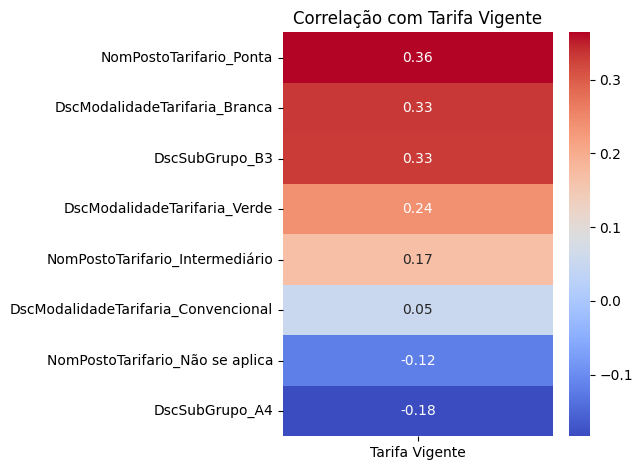

In [ ]:
#Plotar o grafico de correlação com a Tarifa Vigente
sns.heatmap(cor_tarifa.sort_values("Tarifa Vigente", ascending=False), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlação com Tarifa Vigente")
plt.tight_layout()
plt.show()